In [5]:
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import cv2
import os
import time
import multiprocessing
import gc
import warnings
import h5py

from joblib import Parallel, delayed

from skimage import data
from skimage import morphology
from skimage import measure
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, peak_local_max
from skimage.io import imread, imshow
from skimage.color import rgb2hed, hed2rgb, rgb2gray, label2rgb, gray2rgb
from skimage.util import crop, img_as_ubyte, img_as_float, invert
from skimage.filters import threshold_otsu, threshold_local, rank
from skimage.segmentation import clear_border
from skimage.exposure import adjust_gamma
from skimage.transform import match_histograms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from scipy.interpolate import UnivariateSpline
from scipy import ndimage as ndi
from scipy.spatial import Delaunay, ConvexHull
from shapely.geometry.polygon import Polygon

from functions import *

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
os.chdir('/home/tien/Documents/tests/ISUP_test/results/')
with open('dataframe_ISUP_20X.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
df['mean_polygon_areas'] = df['polygon_areas'].apply(np.mean)

In [8]:
df

grades         images                                           polygons  \
0     GS_33  480_20X_3.jpg  [POLYGON ((23 10, 9.729559748427674 26.0691823...   
1     GS_33   1126_20X.jpg  [POLYGON ((5.821917808219178 1578.397260273973...   
2     GS_33  628_20X_2.jpg  [POLYGON ((9.527777777777779 29.03703703703704...   
3     GS_33    480_20X.jpg  [POLYGON ((870.1269841269841 1435.767195767196...   
4     GS_33   1014_20X.jpg  [POLYGON ((19.50884955752212 292.212389380531,...   
5     GS_33  480_20X_2.jpg  [POLYGON ((1986.584745762712 2036.533898305085...   
6     GS_33    628_20X.jpg  [POLYGON ((45.87301587301587 2024.293650793651...   
7     GS_33   1078_20X.jpg  [POLYGON ((1105.625 1562.857142857143, 1190.89...   
8     GS_33   1022_20X.jpg  [POLYGON ((870.0540540540541 1592.067567567567...   
9     GS_33    990_20X.jpg  [POLYGON ((13.77027027027027 73.05405405405405...   
10    GS_33    343_20X.jpg  [POLYGON ((789.4171428571428 2041.388571428571...   
11    GS_33  343_20X_2.jpg  [POLYGON ((98.16463414634147 2022.40243902439,...   
12    GS_33   1026_20X.jpg  [POLYGON ((89.93162393162393 1586.931623931624...   
13    GS_33   1062_20X.jpg  [POLYGON ((1191.342857142857 603.9795918367347...   
14    GS_33   1098_20X.jpg  [POLYGON ((126.7272727272727 15.98484848484848...   
15    GS_33   1074_20X.jpg  [POLYGON ((1165.300546448088 1583.579234972678...   
16    GS_33    118_20X.jpg  [POLYGON ((1995.628272251309 1980.099476439791...   
17    GS_33    207_20X.jpg  [POLYGON ((1988.070422535211 368.056338028169,...   
18    GS_33   1346_20X.jpg  [POLYGON ((1192.36 748.64, 1191.75572519084 72...   
19    GS_33    600_20X.jpg  [POLYGON ((1986.5 2016, 2036.111111111111 2001...   
20    GS_33   1358_20X.jpg  [POLYGON ((1156.64 116.64, 1141.945544554455 7...   
21    GS_33  480_20X_4.jpg  [POLYGON ((41.74626865671642 6.08955223880597,...   
22    GS_33   1002_20X.jpg  [POLYGON ((7.051428571428572 679.1028571428571...   
23    GS_33   1354_20X.jpg  [POLYGON ((114.1367521367521 94.86324786324786...   
24    GS_33   1146_20X.jpg  [POLYGON ((5.63125 31.58125, 5.952380952380953...   
25    GS_33  207_20X_3.jpg  [POLYGON ((20.57589285714286 1666.410714285714...   
26    GS_33   1362_20X.jpg  [POLYGON ((1162.017543859649 1567.976608187135...   
27    GS_33    826_20X.jpg  [POLYGON ((2038.903846153846 235.5961538461538...   
28    GS_33    554_20X.jpg  [POLYGON ((23.56818181818182 79.04545454545455...   
29    GS_33   1310_20X.jpg  [POLYGON ((8 1385, 8 1538, 4.59375 959.0625, 8...   
..      ...            ...                                                ...   
133   GS_44    275_20X.jpg  [POLYGON ((158.1159420289855 310.3695652173913...   
134   GS_44  613_20X_3.jpg  [POLYGON ((8.416 741.208, 7.639705882352941 12...   
135   GS_44   1334_20X.jpg  [POLYGON ((5 247.3962264150943, 7.928571428571...   
136   GS_44    227_20X.jpg  [POLYGON ((12.5 71.5609756097561, 16.936170212...   
137   GS_44  306_20X_2.jpg  [POLYGON ((2038.280193236715 126.6811594202899...   
138   GS_44  613_20X_2.jpg  [POLYGON ((576.8518518518518 1432.118518518519...   
139   GS_44  832_20X_3.jpg  [POLYGON ((220.8165680473373 1708.189349112426...   
140   GS_44    306_20X.jpg  [POLYGON ((68.15625 2029.984375, 66.84375 2036...   
141   GS_44   1298_20X.jpg  [POLYGON ((1193 826.5, 1179.810650887574 424.2...   
142   GS_44  306_20X_4.jpg  [POLYGON ((104.5 1162, 541.777027027027 389.58...   
143   GS_44   1050_20X.jpg  [POLYGON ((9.761904761904763 921.5793650793651...   
144  GS_910    664_20X.jpg  [POLYGON ((9.963503649635037 17.30656934306569...   
145  GS_910  141_20X_2.jpg  [POLYGON ((1044.36 2037.36, 1748.430463576159 ...   
146  GS_910  635_20X_2.jpg  [POLYGON ((2027.046783625731 1881.514619883041...   
147  GS_910    635_20X.jpg  [POLYGON ((2038.450549450549 2019.813186813187...   
148  GS_910  793_20X_3.jpg  [POLYGON ((1750.142857142857 2037.625, 2037.63...   
149  GS_910  242_20X_2.jpg  [POLYGON ((9.231481481481481 723.3981481481482...   
150  GS_910    141_20X.jpg  [POLYGON

In [9]:
mean_areas_33 = df.loc[df['grades']=='GS_33', ['mean_polygon_areas']].values
mean_areas_34 = df.loc[df['grades']=='GS_34', ['mean_polygon_areas']].values
mean_areas_43 = df.loc[df['grades']=='GS_43', ['mean_polygon_areas']].values
mean_areas_44 = df.loc[df['grades']=='GS_44', ['mean_polygon_areas']].values
mean_areas_910 = df.loc[df['grades']=='GS_910', ['mean_polygon_areas']].values

mean_areas = [mean_areas_33, mean_areas_34, mean_areas_43, mean_areas_44, mean_areas_910]

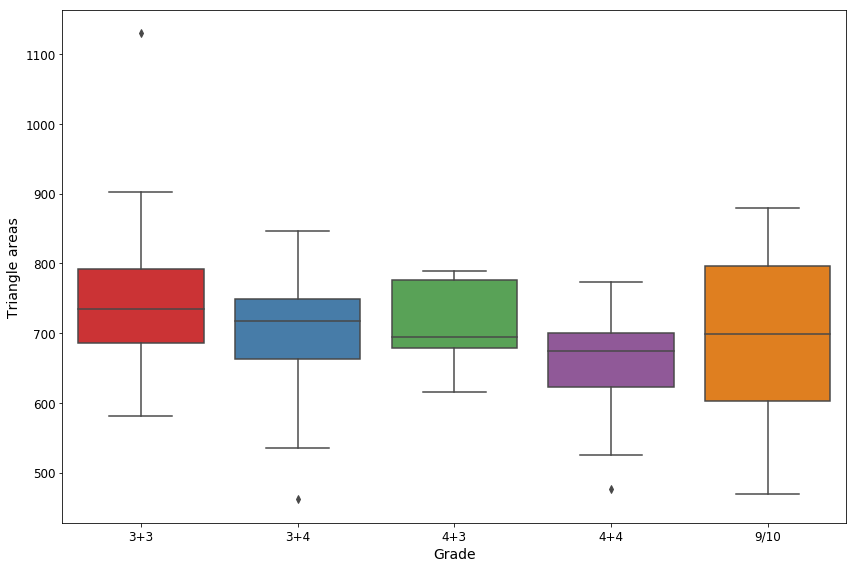

In [10]:
%matplotlib inline
plt.figure(figsize=(12,8))
#sns.set(style="whitegrid")
#sns.set_context("talk")
ax = sns.boxplot(data=np.array(mean_areas), palette="Set1")
ax.set_xticklabels(['3+3', '3+4', '4+3', '4+4', '9/10'])
ax.set_ylabel('Triangle areas')
ax.set_xlabel('Grade')
plt.tight_layout()
#plt.savefig('/home/tien/Documents/presentations/boxplot_polygon_areas.png', transparent=True)
plt.show()

In [11]:
outliers_33 = sorted([y for stat in boxplot_stats(mean_areas_33) for y in stat['fliers']])
images_outliers_33 = [df.loc[df['mean_polygon_areas'] == outliers]['images'].values[0] for outliers in outliers_33]

In [13]:
images_outliers_33

['554_20X.jpg']

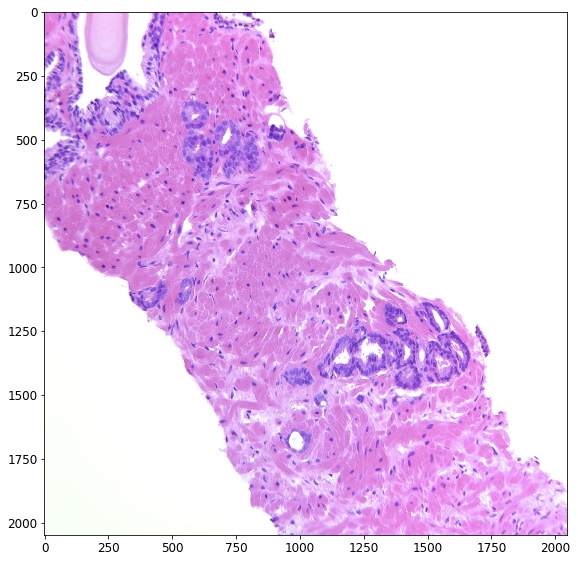

In [14]:
os.chdir('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/')
plt.figure(figsize=(8,8))
imshow(imread(images_outliers_33[0]))

In [61]:
points_test = np.array(df.loc[df['images'] == '255_20X.jpg', ['points']].values.tolist()[0][0])

In [62]:
points_test

array([[   7.        ,  202.75925926],
       [   6.84860558, 1738.99203187],
       [  10.5       , 1618.        ],
       ...,
       [2037.62307692,  427.83846154],
       [2038.        ,  718.        ],
       [2041.21019108,   26.76433121]])

In [66]:
def doAgglomerative(X, dist_thresh):
    model = AgglomerativeClustering(n_clusters=None, affinity = 'euclidean', compute_full_tree=True, distance_threshold=dist_thresh)
    clust_labels = model.fit_predict(X)
    return (clust_labels)

In [81]:
clust_labels = doAgglomerative(points_test, 30) # retourne le label du cluster pour chaque point
agglomerative = pd.DataFrame(clust_labels) # séquence : point # : label
labels = np.unique(clust_labels) # Unique values of cluster labels [0,1,2,...]

clusters_indices = [np.where(clust_labels==i) for i in labels] # 
points_clusters = [points_test[clusters_indices[i]] for i in range(len(clusters_indices))] # Coordonnées dans chacun des clusters
hull_clusters = [ConvexHull(points_clusters[i]) for i in range(len(points_clusters))] # Calcul du plus petit polygone convexe qui entoure chaque point appartenant à chaque cluster

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1161252255  incidence  Qtriangulate  _pre-merge  _zero-centrum


In [80]:
points_clusters[1]

array([[1519.62962963,  780.38271605],
       [1526.53488372,  778.65116279],
       [1526.85606061,  794.6969697 ],
       [1532.53846154,  796.01923077],
       [1538.49333333,  798.33333333]])

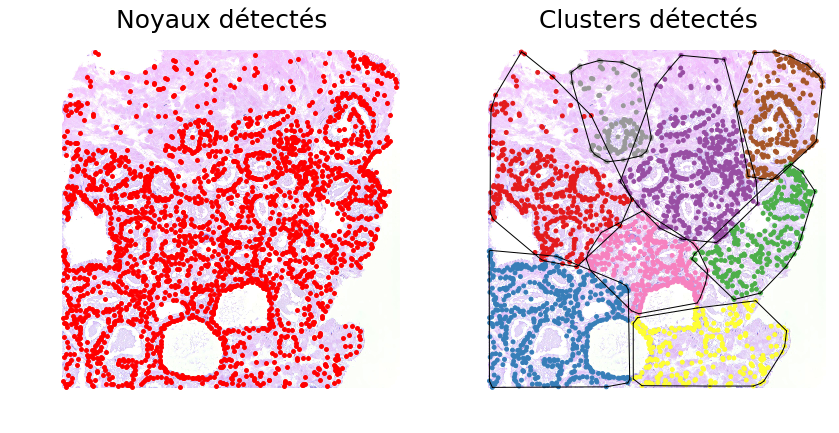

In [65]:
image = imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_33/255_20X.jpg')

f, ax = plt.subplots(1, 2, figsize=(14,8))

size = 15
ax[0].imshow(image)
ax[0].scatter(points_test[:,1], points_test[:,0], s=size, color='red')
ax[0].set_title('Noyaux détectés', fontsize=25)

ax[1].imshow(image)
for i, hull in enumerate(hull_clusters) :
    for simplex in hull.simplices :
       ax[1].plot(points_clusters[i][simplex,1], points_clusters[i][simplex,0], 'k-', lw=1)
ax[1].scatter(points_test[:,1], points_test[:,0], s=size, c=agglomerative[0], cmap='Set1')
ax[1].set_title('Clusters détectés', fontsize=25)

for a in ax :
    a.axis('off')

#plt.savefig('/home/tien/Documents/presentations/clusters_exemple.png', transparent=True)
plt.show()